# Demonstration of the TuringOnline package

In this notebook we will provide a use case of the TuringOnline package in order to illustrate its benefits and to provide evidence for the correct working.

The package aims to provide online updates of inferred parameter sets, given parameter samples from e.g. a MCMC algorithm and new, i.e. previously unseen data.

The notebook is structured as follows:

## Table of contents
1. [Used packages](#import)
1. [Model](#model)    
1. [Data generation](#data)
    1. [Independent variables](#data_indep)
    1. [Dependent variables](#data_dep)
    1. [Suitability of generated data](#data_suit)
1. [Benchmark](#bench)
    1. [Speed and memory consumption](#bench_speed)
    1. [Accuracy](#bench_acc)
1. [Repeated updates](#loop)
1. [Summary](#sum)

## Used packages <a name="import"></a>

In [1]:
import PyPlot as plt
import Seaborn as sns
import Pandas as pd

In [2]:
import Random as rnd
import Distributions as dist

In [3]:
import Turing as tur

In [4]:
import AdvancedPS as aps

In [5]:
import DynamicPPL as ppl

In [6]:
rng = rnd.seed!(1)

MersenneTwister(1)

In [7]:
include("../src/TuringOnline.jl")
using Revise
import .online as online

In [8]:
include("./scoring.jl")
import .scoring as scoring

In [9]:
using BenchmarkTools

In [10]:
using Suppressor

## Model <a name="model"></a>

In [11]:
# The TV syntax allows sampling to be type-stable.
tur.@model function garch(y)
    T = length(y)

    # Declare priors on parameters.
    omega ~ dist.TruncatedNormal(0,1,0,Inf)
    alpha ~ dist.TruncatedNormal(0,1,0,Inf)
    beta ~ dist.TruncatedNormal(0,1,0,Inf)

    # Initialize conditional variance vector.
    #sigmaSquared =  ones(T)#Vector{Float64}(undef, T)

    # Treat the first h as a parameter to estimate.
    #sigmaSquared[1] ~ dist.Exponential(1)#dist.TruncatedNormal(0,1,0,Inf)
    
    sigmaSquared ~ tur.filldist(dist.Exponential(1),T)
    
    
    # if y is missing, use a sample for y[1]
    if y[1] === missing
        y[1] ~ dist.Normal(0, 1)
    end
    
    # Observe each data point.
    for t in 2:T
        sigmaSquared[t] = omega + alpha * y[t-1]^2 + beta * sigmaSquared[t-1]
        y[t] ~ dist.Normal(0, sqrt(sigmaSquared[t]))
    end
    
    return (y=y,omega=omega,alpha=alpha,beta=beta)
end

garch (generic function with 2 methods)

In [12]:
missing_y =  fill(missing,4);

In [13]:
m_missing_full = garch(missing_y)

DynamicPPL.Model{typeof(garch), (:y,), (), (), Tuple{Vector{Missing}}, Tuple{}, DynamicPPL.DefaultContext}(:garch, garch, (y = [missing, missing, missing, missing],), NamedTuple(), DynamicPPL.DefaultContext())

In [14]:
prior_chain = tur.sample(m_missing_full, tur.Prior(), 2)

Chains MCMC chain (2×12×1 Array{Float64, 3}):

Iterations        = 1:1:2
Number of chains  = 1
Samples per chain = 2
Wall duration     = 3.14 seconds
Compute duration  = 3.14 seconds
parameters        = omega, alpha, beta, sigmaSquared[1], sigmaSquared[2], sigmaSquared[3], sigmaSquared[4], y[1], y[2], y[3], y[4]
internals         = lp

Summary Statistics
       parameters      mean       std   naive_se      mcse       ess      rhat ⋯
           Symbol   Float64   Float64    Float64   Float64   Missing   Missing ⋯

            omega    0.3528    0.0786     0.0556    0.0556   missing   missing ⋯
            alpha    0.2516    0.1850     0.1308    0.1308   missing   missing ⋯
             beta    0.5535    0.3428     0.2424    0.2424   missing   missing ⋯
  sigmaSquared[1]    1.7137    1.2552     0.8875    0.8875   missing   missing ⋯
  sigmaSquared[2]    1.5261    1.2335     0.8722    0.8722   missing   missing ⋯
  sigmaSquared[3]    0.3843    0.4401     0.3112    0.3112   missing   miss

In [15]:
generated = tur.generated_quantities(m_missing_full, prior_chain);

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311


In [16]:
y = tur.generated_quantities(m_missing_full, prior_chain)[1][:y]

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311


4-element Vector{Union{Missing, Float64}}:
  0.5837082875687786
  1.0712882891875655
  0.48574337995820105
 -0.4481915863885648

In [17]:
trueVals = Dict()

Dict{Any, Any}()

In [18]:
parameters = [:omega,:alpha,:beta]

3-element Vector{Symbol}:
 :omega
 :alpha
 :beta

In [19]:
@suppress begin

for key in parameters
    trueVals[key] = tur.generated_quantities(m_missing_full, prior_chain)[1][key]
end
trueVals
end

Dict{Any, Any} with 3 entries:
  :omega => 0.297288
  :alpha => 0.382396
  :beta  => 0.311111

### Show the data

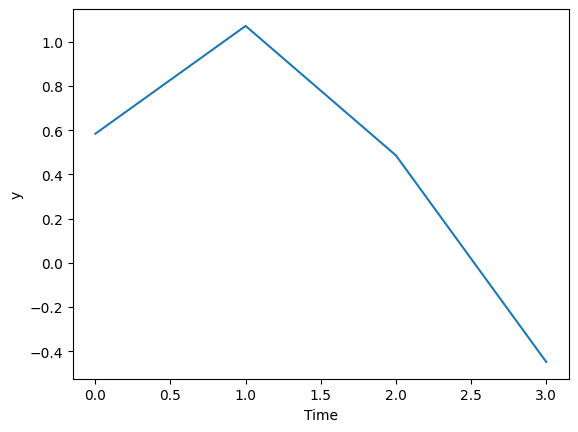

In [20]:
plt.plot(y);
plt.ylabel("y");
plt.xlabel("Time");

### Show suitablity by inference through NUTS with full data <a name="data_suit"></a>
We consider the NUTS algorithm as a reference standard and show that the data contains enough information for a meaningful inference.

In [21]:
m_full = garch(y);

In [22]:
NUTS = tur.NUTS();

In [23]:
num_chains = 2
num_samples = 1000;

In [24]:
chain_NUTS_full =  tur.sample(m_full, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


In [25]:
summaryNUTS = tur.summarize(chain_NUTS_full).nt

(parameters = [:omega, :alpha, :beta, Symbol("sigmaSquared[1]"), Symbol("sigmaSquared[2]"), Symbol("sigmaSquared[3]"), Symbol("sigmaSquared[4]")], mean = [0.6084952691065371, 0.6631856786990851, 0.547532539031221, 0.9203454568107867, 1.0039213923991308, 1.0041410602997844, 1.008222582901363], std = [0.5134363665990851, 0.5423737933390778, 0.44877958899436965, 0.9376733180881831, 1.031982887663709, 1.0209475385079712, 0.996981322729431], naive_se = [0.01148078617836056, 0.01212784671120601, 0.01003501667905826, 0.02096701279932962, 0.0230758388843258, 0.022829080975649063, 0.022293180099206625], mcse = [0.015469143172121341, 0.013108227556596854, 0.010795362491660684, 0.020649043276240966, 0.02638142869726036, 0.02117388432517735, 0.018958839965912713], ess = [1208.3332306829368, 1902.8601132099225, 2241.3965266308137, 2277.8376038072543, 1503.775199723771, 2449.9831657074997, 2079.898587125569], rhat = [0.9996011645695525, 1.0001915431179247, 0.9998894071074225, 0.9993806974357323, 0.9

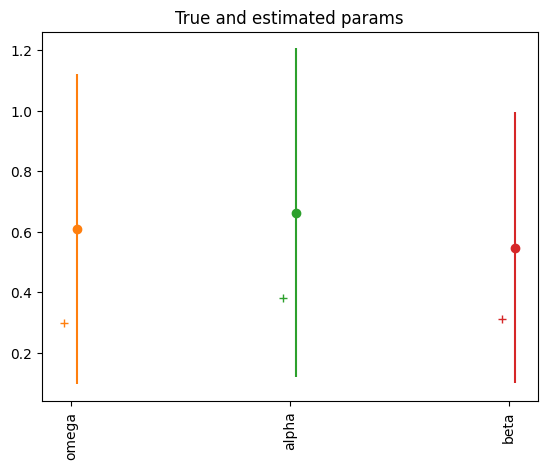

In [26]:
jitter = 0.03
plt.title("True and estimated params")
for (i,p) in enumerate(parameters)
  plt.plot(i-jitter,trueVals[p],"+",label="True",color="C$i");
  plt.errorbar(x=i+jitter,y=summaryNUTS.mean[i],yerr=summaryNUTS.std[i],fmt="o",color="C$i",label="Est")
end

# ticks
plt.xticks(1:length(parameters), parameters, rotation="vertical")

#plt.legend();
#plt.ylabel("theta")
#plt.xlabel("Time");

In [27]:
scoring.getScore(chain_NUTS_full,[:omega,:alpha,:beta],trueVals)

3.2566543795123963

## Benchmark of updating <a name="bench"></a>
We consider the situation where data and inferred parameters up to a point t in time are available and new data arrives at time t+1.

In [28]:
someTime = size(missing_y,1)-1

3

In [29]:
y_t =  y[1:someTime]

3-element Vector{Union{Missing, Float64}}:
 0.5837082875687786
 1.0712882891875655
 0.48574337995820105

In [30]:
y_t_inc = y[1:someTime+1]

4-element Vector{Union{Missing, Float64}}:
  0.5837082875687786
  1.0712882891875655
  0.48574337995820105
 -0.4481915863885648

In [31]:
model_t = garch(y_t)

DynamicPPL.Model{typeof(garch), (:y,), (), (), Tuple{Vector{Union{Missing, Float64}}}, Tuple{}, DynamicPPL.DefaultContext}(:garch, garch, (y = Union{Missing, Float64}[0.5837082875687786, 1.0712882891875655, 0.48574337995820105],), NamedTuple(), DynamicPPL.DefaultContext())

In [32]:
model_t_inc = garch(y_t_inc)

DynamicPPL.Model{typeof(garch), (:y,), (), (), Tuple{Vector{Union{Missing, Float64}}}, Tuple{}, DynamicPPL.DefaultContext}(:garch, garch, (y = Union{Missing, Float64}[0.5837082875687786, 1.0712882891875655, 0.48574337995820105, -0.4481915863885648],), NamedTuple(), DynamicPPL.DefaultContext())

#### Get a chain from nuts
We assume here that the parameter set up to time t is also available, we use NUTS as a reference for that:

In [33]:
chain_t = tur.sample(model_t, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true)

┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Chains MCMC chain (1000×18×2 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 2
Samples per chain = 1000
Wall duration     = 3.6 seconds
Compute duration  = 7.17 seconds
parameters        = omega, alpha, beta, sigmaSquared[1], sigmaSquared[2], sigmaSquared[3]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
       parameters      mean       std   naive_se      mcse         ess      rh ⋯
           Symbol   Float64   Float64    Float64   Float64     Float64   Float ⋯

            omega    0.7265    0.5494     0.0123    0.0141   1733.0784    1.00 ⋯
            alpha    0.7444    0.5720     0.0128    0.0141   1715.8323    1.00 ⋯
             beta    0.6611    0.5231     0.0117    0.0111   1771.7473    1.00 ⋯
  sigmaSquared[1]    0.9349    0.9009     0.0201    0.0175   2138.3653    0.99 ⋯
  sigm

### Speed and memory consumption <a name="bench_speed"></a>

In [34]:
@benchmark online.update(chain_t,model_t_inc,tur.SMC(),rng) seconds = 20

Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model

BenchmarkTools.Trial: 27 samples with 1 evaluation.
 Range (min … max):  628.120 ms …    1.113 s  ┊ GC (min … max): 15.11% … 49.40%
 Time  (median):     734.050 ms               ┊ GC (median):    17.76%
 Time  (mean ± σ):   766.318 ms ± 136.106 ms  ┊ GC (mean ± σ):  22.62% ±  9.77%

   ▃▃ ▃      ▃ █ ▃                                               
  ▇██▇█▁▁▇▁▇▇█▁█▇█▇▁▁▁▁▇▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▇▁▁▁▇▇▁▁▁▁▁▁▁▁▇ ▁
  628 ms           Histogram: frequency by time          1.11 s <

 Memory estimate: 697.25 MiB, allocs estimate: 2518329.

In [35]:
@benchmark tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true) seconds = 20

┌ Info: Found initial step size
│   ϵ = 0.8125
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.41250000000000003
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8500000000000001
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.30000000000000004
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:18

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ 

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ 

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.45
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @

┌ Info: Found initial step size
│   ϵ = 0.40078125000000003
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size


┌ Info: Found initial step size
│   ϵ = 0.8250000000000001
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│

BenchmarkTools.Trial: 73 samples with 1 evaluation.
 Range (min … max):  221.527 ms … 370.499 ms  ┊ GC (min … max): 15.84% … 20.55%
 Time  (median):     268.504 ms               ┊ GC (median):    22.49%
 Time  (mean ± σ):   274.278 ms ±  27.214 ms  ┊ GC (mean ± σ):  22.23% ±  3.93%

             ▁ ▁▃▁▃▃█ ▆   ▃   ▃▁     ▁                           
  ▇▄▁▁▁▁▁▁▁▇▁█▄██████▄█▇▇▇█▁▄▇██▄▁▁▇▄█▁▁▁▁▄▇▄▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▄ ▁
  222 ms           Histogram: frequency by time          361 ms <

 Memory estimate: 268.15 MiB, allocs estimate: 2111669.

The two results above indicate that the online updates is faster and requires less memory.

### Accuracy <a name="bench_acc"></a>
We compare the estimated values from the online update and from NUTS to the true values.

In [36]:
newChain = online.update(chain_t,model_t_inc,tur.SMC(),rng);

Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.


In [37]:
scoring.getScore(newChain,[:omega,:alpha,:beta],trueVals)

2.144332451642737

In [38]:
chain_t_inc = tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);

┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


In [39]:
scoring.getScore(chain_t_inc,[:omega,:alpha,:beta],trueVals)

3.2747107075112174

In [40]:
dictChains = Dict("Update" => newChain, "NUTS" => chain_t_inc , "True" => prior_chain);

In [41]:
dictColor = Dict("Update" => "C1", "NUTS" => "C2" , "True" => "k");

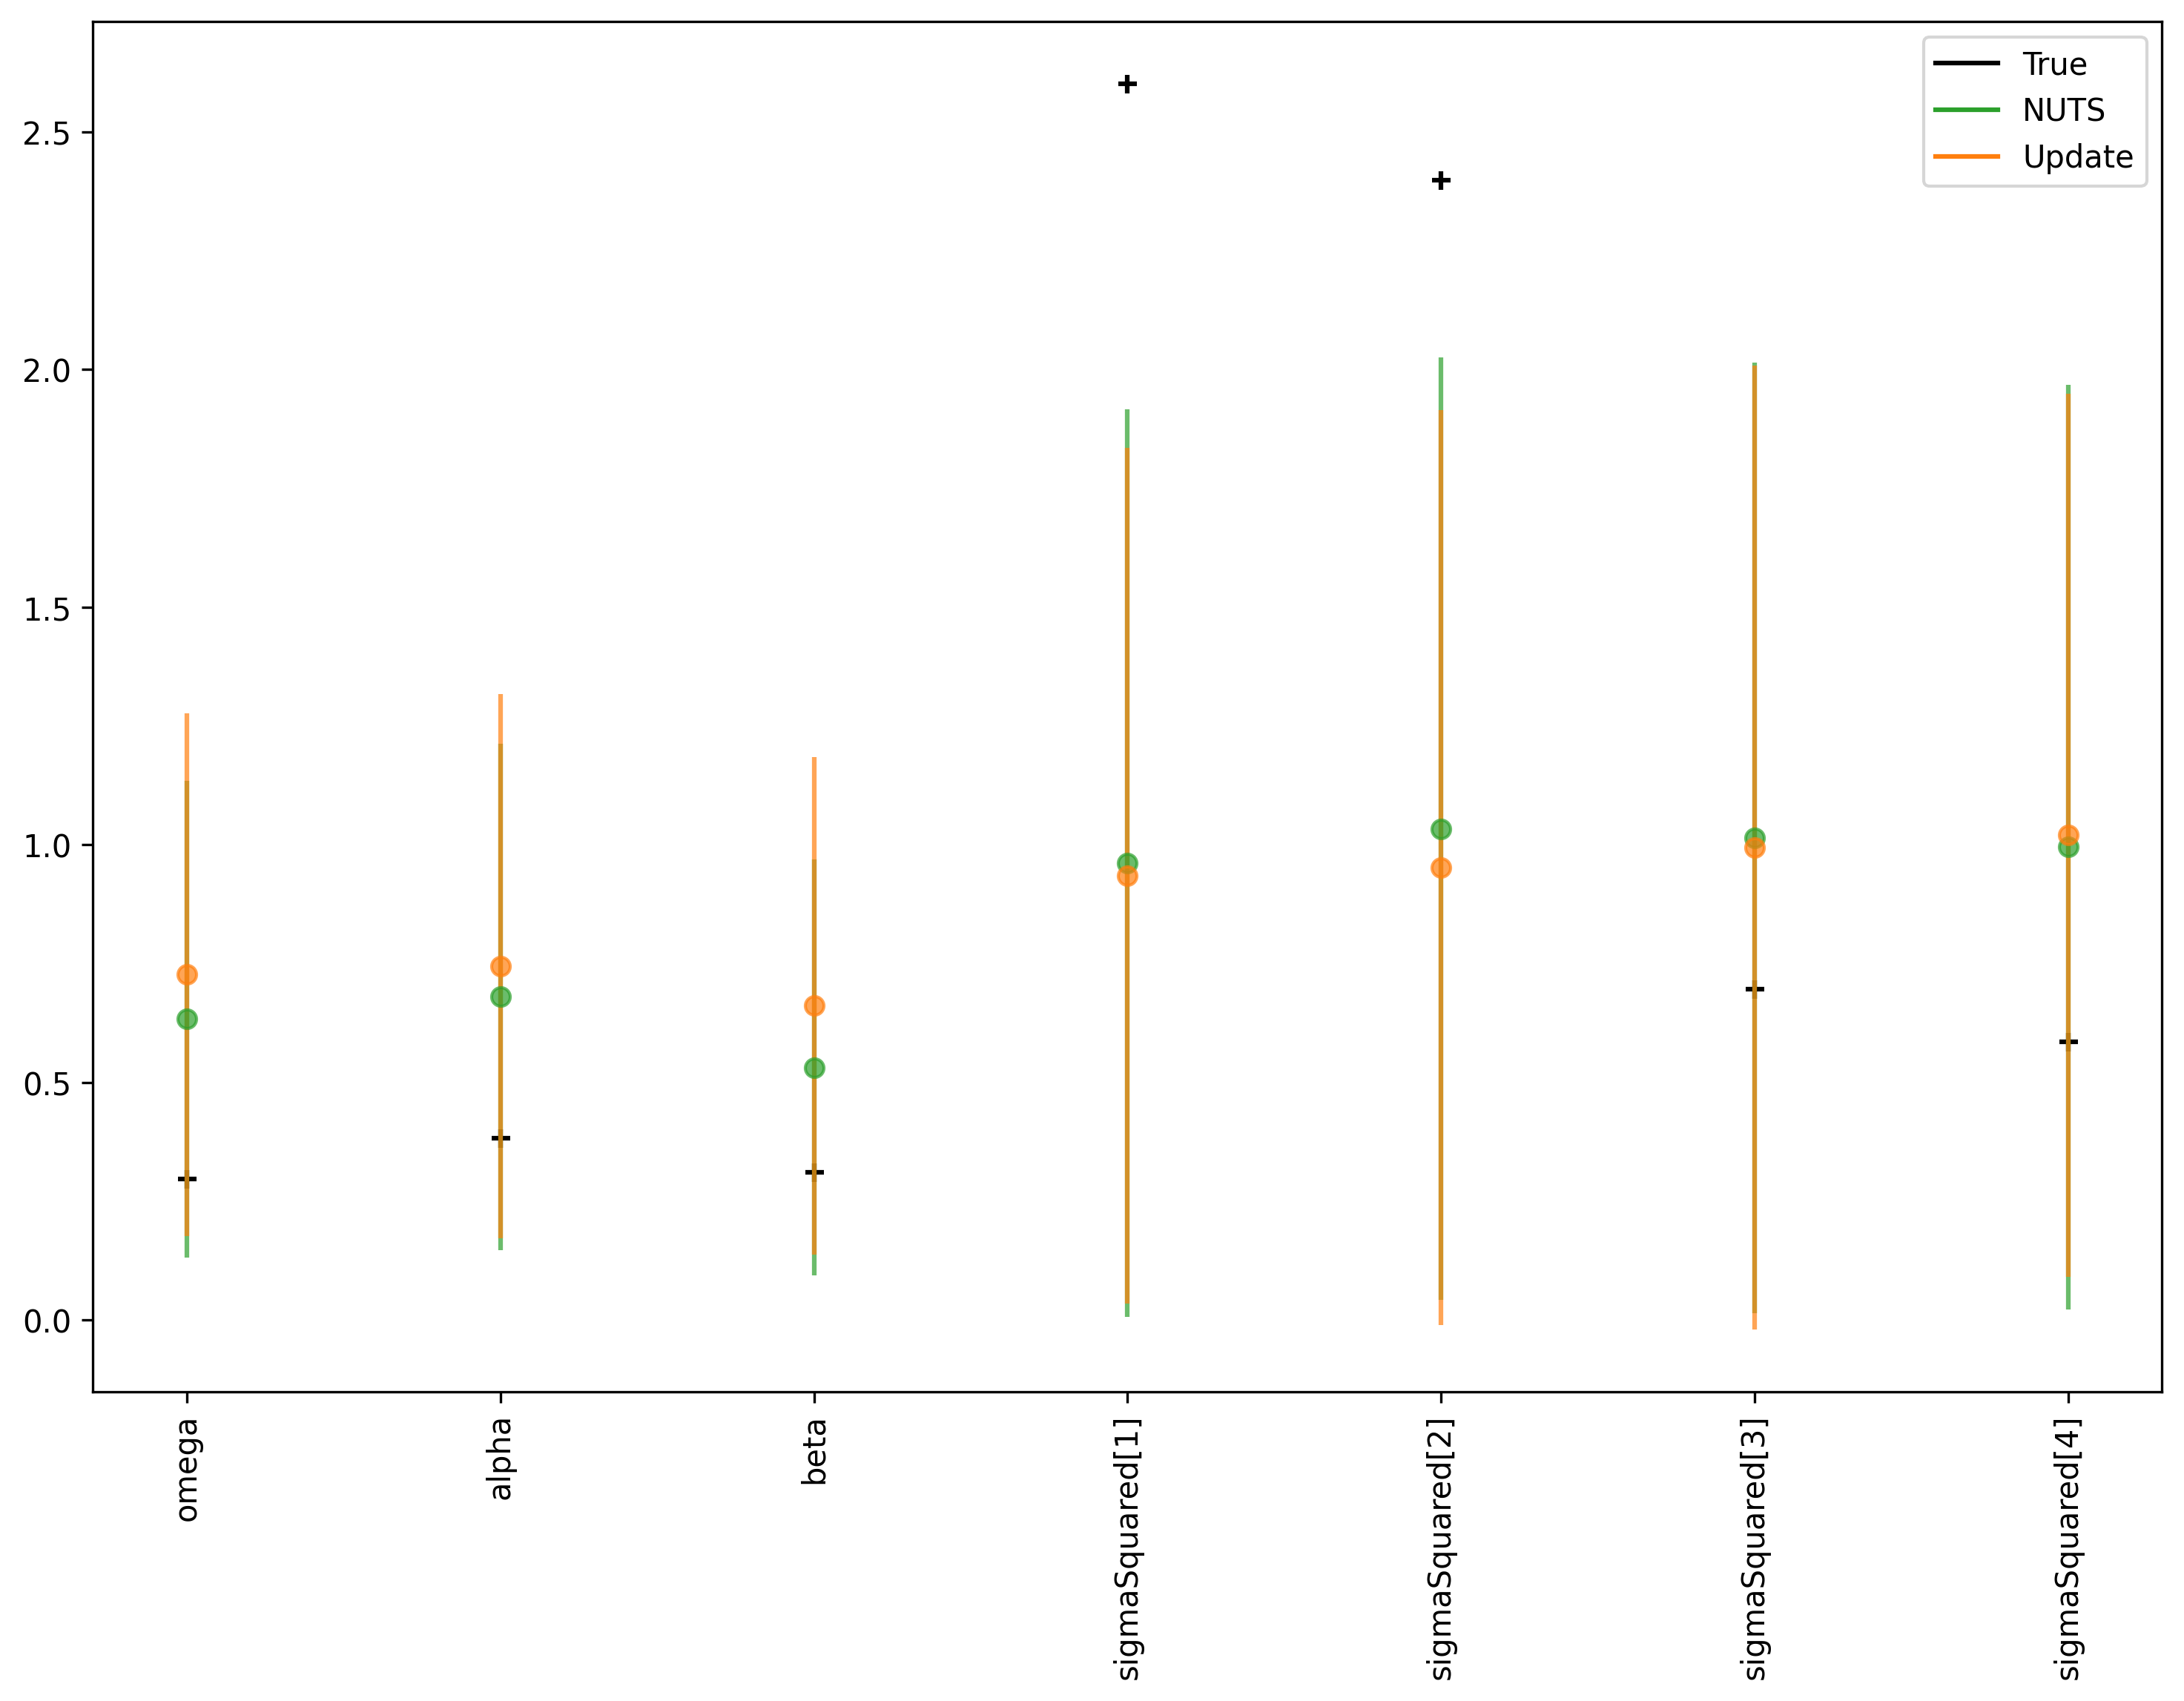

In [42]:
plt.figure(figsize=(12,8),dpi=300)
for (i,sym) in enumerate(chain_t_inc.name_map.parameters)
    for (k,v) in dictChains
        if sym in v.name_map.parameters
            if k != "True"
                # compute statistics
                samples = collect(Iterators.flatten(v[sym].data))
                mean = dist.mean(samples)
                std = dist.std(samples)
                
                # plot errorbars
                plt.errorbar(x=i,y=mean,yerr=std,fmt="o",color=dictColor[k],alpha=0.7)
            else 
                # plot true
                plt.scatter([i],v[sym].data[1,:],color="k",marker="+")
            end
        end        
    
    end
end
# add labels
for (ckey,cvalue) in dictColor
    plt.plot([],[],label=ckey,color=cvalue)
end
plt.legend()

# ticks
plt.xticks(1:length(chain_t_inc.name_map.parameters), chain_t_inc.name_map.parameters, rotation="vertical")

plt.show()

The performance of both algorithms is similar as all estimates are within a fraction of the corresponding standard deviations.

## Repeated updates <a name="loop"></a>
We investigate the repeated use of the online update over a time series.

In [43]:
chainDict = Dict()

Dict{Any, Any}()

In [44]:
smc = tur.SMC()

Turing.Inference.SMC{(), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}(AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}(AdvancedPS.resample_systematic, 0.5))

In [45]:
for i in 1:size(y,1)
    
    # set up model
    model_t = garch(y[1:i])
    
    if i == 1
        println("NUTS at $i")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, tur.SMC(), tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    elseif i == 2
        println("NUTS at $i")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("Online at $i")
        chainDict[(i,"Online")] = online.update(chainDict[(i-1,"NUTS")],model_t,smc,rng)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, tur.SMC(), tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    else        
        println("NUTS at $i.")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, tur.SMC(), tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("Online at $i")
        try
            chainDict[(i,"Online")] = online.update(chainDict[(i-1,"Online")],model_t,tur.SMC(),rng)
        catch e
            chainDict[(i,"Online")] = chainDict[(i-1,"Online")]
        end
    end
end

NUTS at 1
SMC at 1


┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


NUTS at 2
Online at 2
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[2]")]) 
Using prior samples from the model for them instead.


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


SMC at 2
NUTS at 3.
SMC at 3
Online at 3


┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[3]")]) 
Using prior samples from the model for them instead.
NUTS at 4.
SMC at 4
Online at 4
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("sigmaSquared[4]")]) 
Using prior samples from the model for them instead.


┌ Info: Found initial step size
│   ϵ = 0.30000000000000004
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


### Analysis

In [46]:
chainDict

Dict{Any, Any} with 11 entries:
  (2, "SMC")    => MCMC chain (100×7×2 Array{Float64, 3})
  (3, "NUTS")   => MCMC chain (100×18×2 Array{Float64, 3})
  (3, "Online") => MCMC chain (100×8×2 Array{Float64, 3})
  (1, "SMC")    => MCMC chain (100×6×2 Array{Float64, 3})
  (4, "NUTS")   => MCMC chain (100×19×2 Array{Float64, 3})
  (4, "Online") => MCMC chain (100×8×2 Array{Float64, 3})
  (2, "NUTS")   => MCMC chain (100×17×2 Array{Float64, 3})
  (2, "Online") => MCMC chain (100×7×2 Array{Float64, 3})
  (3, "SMC")    => MCMC chain (100×8×2 Array{Float64, 3})
  (1, "NUTS")   => MCMC chain (100×16×2 Array{Float64, 3})
  (4, "SMC")    => MCMC chain (100×9×2 Array{Float64, 3})

In [47]:
function plotEstimates(chainDict,name,prior_chain)
    # time indices
    times = sort(unique([t for (t,m) in keys(chainDict)]))
    
    colorDict = Dict("NUTS" => "C0","Online" => "C1","SMC" => "C2")
    jitter = 0.09
    jitterDict = Dict("NUTS" => -jitter,"Online" => 0.0,"SMC" => jitter)
    
    methods = ["NUTS","Online","SMC"]
    
    # extract values
    for method in methods
        for t in times
            key = (t,method)           
            if haskey(chainDict, key) && Symbol(name) in chainDict[key].name_map.parameters
                samples = collect(Iterators.flatten(chainDict[key][Symbol(name)].data))                
                mean = dist.mean(samples)
                std = dist.std(samples)
                
                # pseudo x with jitter
                x = t
                x += jitterDict[method]

                # plot errorbars
                plt.errorbar(x=x,y=mean,yerr=std,fmt="o",color=colorDict[method])
            end
        end    
    end

    # Add legend
    for method in methods
       plt.plot([],[],color=colorDict[method],label=method) 
    end    
    
    # Show true value
    trueVal = prior_chain[Symbol(name)].data[1,1]
    plt.plot(times,trueVal.*ones(length(times)),color="k",label="True")
    plt.legend()
    
    # set labels
    plt.ylabel(name)
    plt.xlabel("Timestep")
    
    return nothing
end    

plotEstimates (generic function with 1 method)

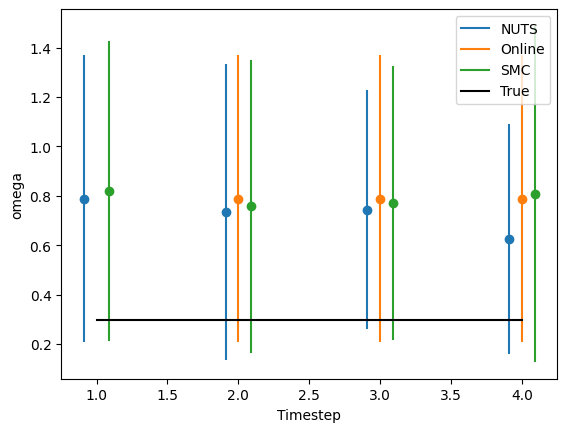

In [48]:
plotEstimates(chainDict,"omega",prior_chain)

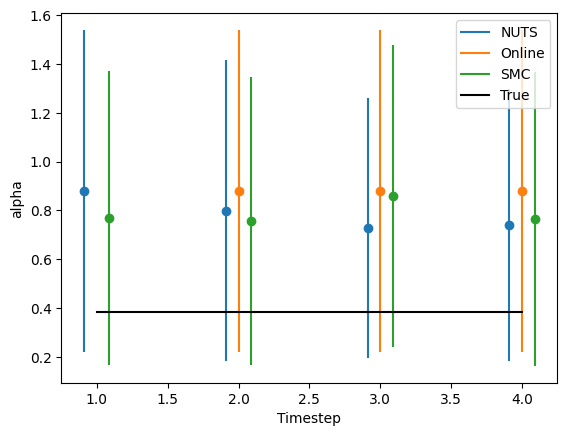

In [49]:
plotEstimates(chainDict,"alpha",prior_chain)

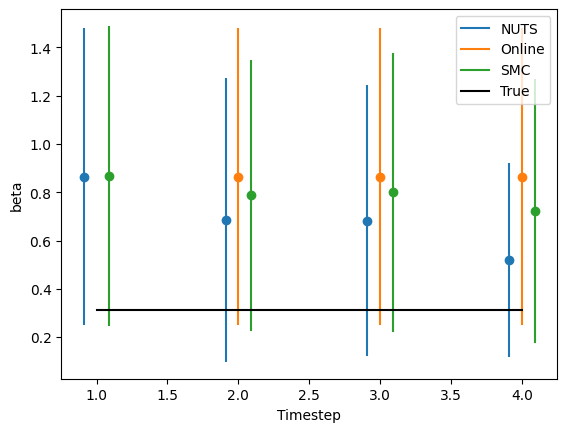

In [50]:
plotEstimates(chainDict,"beta",prior_chain)

In [51]:
function plotScores(chainDict,params,trueVals)
    # time indices
    times = sort(unique([t for (t,m) in keys(chainDict)]))
    
    colorDict = Dict("NUTS" => "C0","Online" => "C1","SMC" => "C2")
    jitter = 0.09
    jitterDict = Dict("NUTS" => -jitter,"Online" => 0.0,"SMC" => jitter)
    
    methods = ["NUTS","Online","SMC"]
    
    # extract values
    for method in methods
        for t in times
            key = (t,method)           
            if haskey(chainDict, key) 
                chain = chainDict[key]
                score = scoring.getScore(chain,params,trueVals)
                
                # pseudo x with jitter
                x = t
                x += jitterDict[method]

                # plot errorbars
                plt.errorbar(x=x,y=score,fmt="o",color=colorDict[method])
            end
        end    
    end

    # Add legend
    for method in methods
       plt.plot([],[],color=colorDict[method],label=method) 
    end  
    plt.legend()
    
    # set labels
    plt.ylabel("Score")
    plt.xlabel("Timestep")
    
    return nothing
end

plotScores (generic function with 1 method)

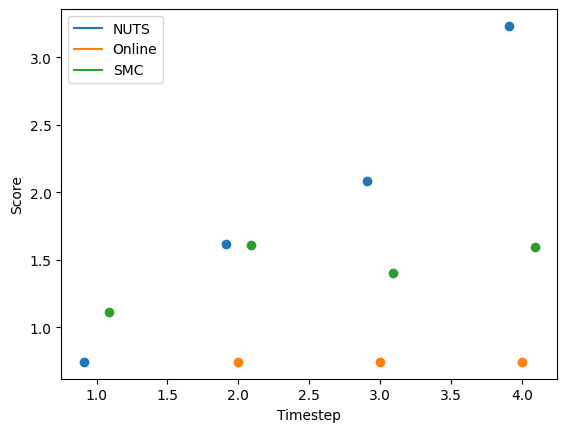

In [52]:
plotScores(chainDict,[:omega,:alpha,:beta],trueVals)

In general, the estimates of the online update agree with the ones of NUTS and the true value within one standard deviation. However, over repteated iterations there is a tendency to converge to narrow range of values. This degenaration could be rooted in the nature of the particle based methods.

## Summary <a name="sum"></a>
We could show that the online updates provided by the TuringOnline package offer a way to get estimates of similar quality, but in less time and with less memory consumption than rerunning the estimation with a reference algorithm like NUTS.

For repteated usage there is the danger of the updated to converge to a narrow range after several updates, such that there may be a certain limit of steps after which one should refresh the estimates by a complete run of e.g. NUTS.